In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Для разделения выборки и финального расчета метрик (чтобы сверить свои реализации)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# Настройка стиля графиков
sns.set(style="whitegrid")

# Загрузка датасета
df = pd.read_csv('famcs_students.csv')
print("Датасет успешно загружен.")
print("Размерность:", df.shape)


Датасет успешно загружен.
Размерность: (127, 25)


In [ ]:
# 1. Определение целевой переменной
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[9 % 8] 
print(f"Целевая переменная (y): {target_col}")

# 2. Выбор признаков (X)
# Мы должны выбрать не менее 5 информативных признаков.
# Возьмем числовые (score, miss, age) и категориальные/бинарные (sex, weekend_study, bad_sleep, anime)
feature_cols = ['score', 'miss', 'age', 'sex', 'weekend_study', 'bad_sleep', 'anime', 'ss']

# Создаем копию рабочего датафрейма
data = df[feature_cols + [target_col]].copy()

# 3. Обработка пропусков (если есть)
data = data.dropna()


def encode_feature(series):
    if pd.api.types.is_numeric_dtype(series):
        return series
    return series.astype('category').cat.codes

for col in data.columns:
    data[col] = encode_feature(data[col])

# Выделяем X и y
X_raw = data[feature_cols].values
y = data[target_col].values

# 5. Масштабирование (StandardScaler) - критично для KNN и ЛогРегрессии
# X_scaled = (X - mean) / std
mean = np.mean(X_raw, axis=0)
std = np.std(X_raw, axis=0)
# Избегаем деления на 0
std[std == 0] = 1 
X = (X_raw - mean) / std

print(f"Размерность матрицы признаков X: {X.shape}")
print(f"Размерность вектора ответов y: {y.shape}")
print("Примеры классов y:", np.unique(y))

Целевая переменная (y): interest
Размерность матрицы признаков X: (127, 8)
Размерность вектора ответов y: (127,)
Примеры классов y: [0 1]


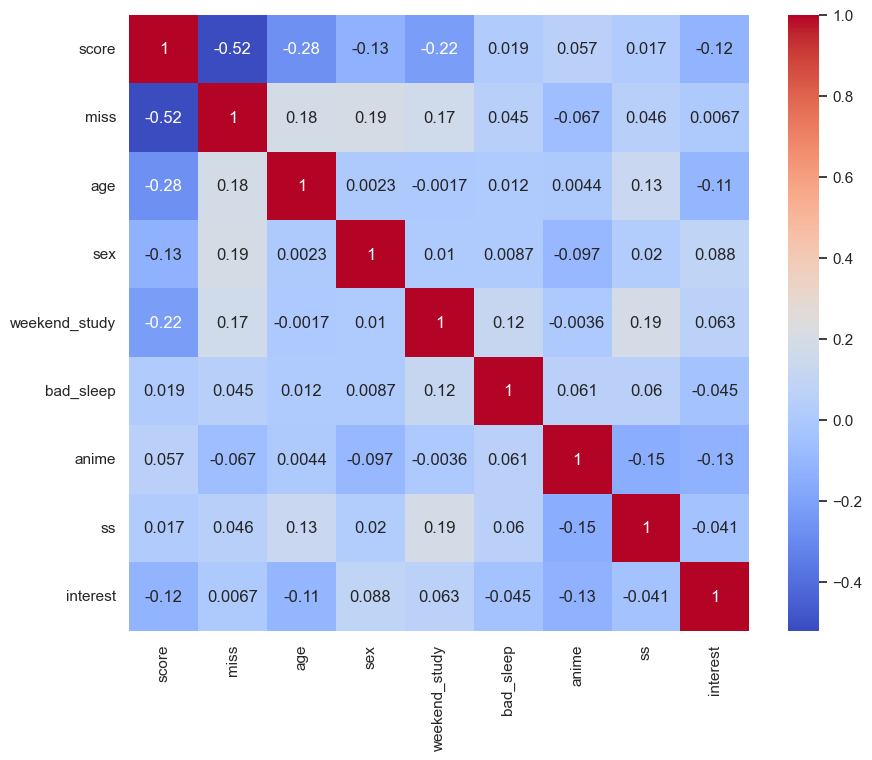

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Разбиваем на Train (70%) и Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Разбиваем Temp на Val (15% от всего -> 50% от Temp) и Test (15% от всего -> 50% от Temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Val shapes:   {X_val.shape}, {y_val.shape}")
print(f"Test shapes:  {X_test.shape}, {y_test.shape}")

Train shapes: (88, 8), (88,)
Val shapes:   (19, 8), (19,)
Test shapes:  (20, 8), (20,)


In [12]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    
    # TP, TN, FP, FN
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Precision & Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # ROC-AUC (используем sklearn для надежности интеграла, но можно реализовать через сортировку)
    roc_auc = roc_auc_score(y_true, y_prob) if y_prob is not None else 0.5
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "conf_matrix": [[TN, FP], [FN, TP]]
    }

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
class TrivialClassifier:
    def fit(self, y):
        counts = Counter(y)
        self.most_frequent_class = counts.most_common(1)[0][0]
    
    def predict(self, X):
        return np.full(X.shape[0], self.most_frequent_class)
    
    def predict_proba(self, X):
        prob = 1.0 if self.most_frequent_class == 1 else 0.0
        return np.full(X.shape[0], prob)

# Обучение
trivial_model = TrivialClassifier()
trivial_model.fit(y_train)

# Проверка
y_pred_triv = trivial_model.predict(X_val)
print(f"Тривиальный классификатор всегда предсказывает класс: {trivial_model.most_frequent_class}")

Тривиальный классификатор всегда предсказывает класс: 1


In [14]:
class CustomGaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-9 # добавляем epsilon для стабильности
            self.priors[c] = X_c.shape[0] / X.shape[0]
            
    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def predict_proba(self, X):
        # Считаем апостериорные вероятности (без нормализации P(X))
        probs = []
        for x in X:
            class_probs = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                # Сумма логарифмов плотности вероятности (Log-Likelihood)
                conditional = np.sum(np.log(self._pdf(c, x)))
                class_probs.append(prior + conditional)
            probs.append(class_probs)
        
        # Переводим лог-вероятности обратно в вероятности через Softmax
        probs = np.array(probs)
        exp_probs = np.exp(probs - np.max(probs, axis=1, keepdims=True)) # shift for stability
        return exp_probs / np.sum(exp_probs, axis=1, keepdims=True)

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

# Обучение
nb_model = CustomGaussianNB()
nb_model.fit(X_train, y_train)

Подбор k для KNN...


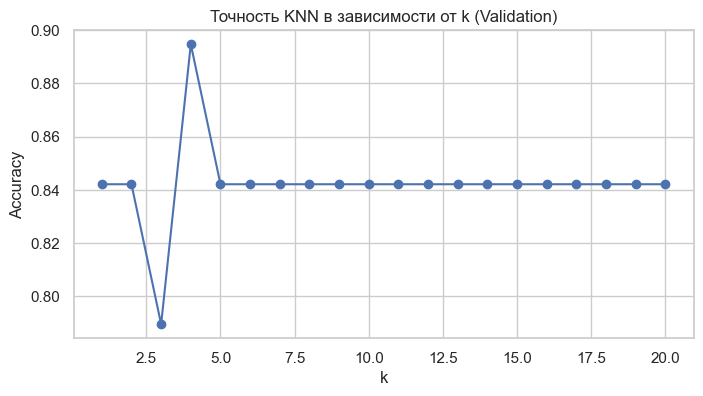

Оптимальный k: 4


In [15]:
class CustomKNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        y_pred = [self._predict_one(x) for x in X]
        return np.array(y_pred)
    
    def _predict_one(self, x):
        # Евклидово расстояние
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        # Индексы k ближайших
        k_indices = np.argsort(distances)[:self.k]
        # Голоса
        k_nearest_labels = self.y_train[k_indices]
        # Мажоритарное голосование
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def predict_proba(self, X):
        # Вероятность = доля соседей положительного класса
        y_probs = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            prob = np.mean(k_nearest_labels == 1)
            y_probs.append(prob)
        return np.array(y_probs)

# Подбор гиперпараметра k на валидационной выборке
best_k = 1
best_acc = 0
k_values = range(1, 21)
acc_scores = []

print("Подбор k для KNN...")
for k in k_values:
    knn = CustomKNN(k=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    acc = np.mean(preds == y_val)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

plt.figure(figsize=(8, 4))
plt.plot(k_values, acc_scores, marker='o')
plt.title("Точность KNN в зависимости от k (Validation)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

print(f"Оптимальный k: {best_k}")

# Обучаем финальную модель KNN
knn_model = CustomKNN(k=best_k)
knn_model.fit(X_train, y_train)

Оптимальный порог классификации: 0.00 (Max F1: 0.914)


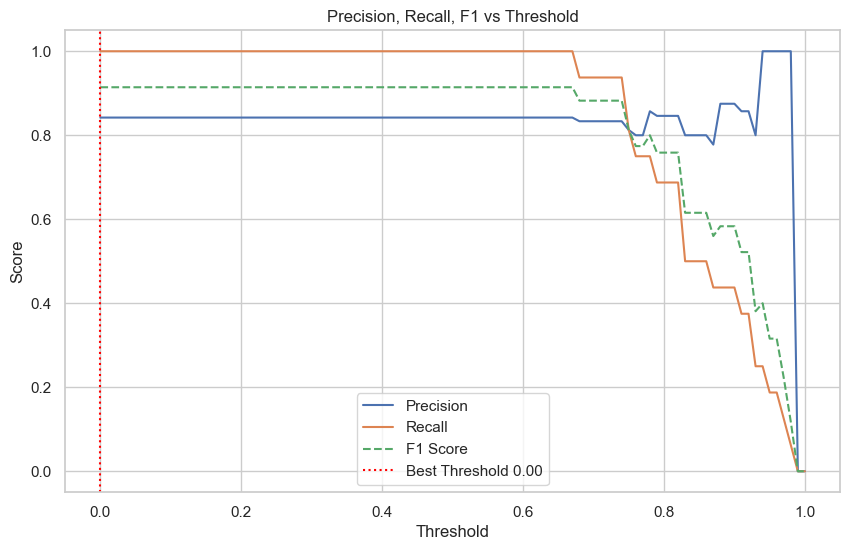

In [16]:
class CustomLogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient Descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            # Gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict_proba_positive(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        y_predicted_cls = [1 if i > threshold else 0 for i in self.predict_proba_positive(X)]
        return np.array(y_predicted_cls)

# Обучение
log_reg = CustomLogisticRegression(lr=0.1, n_iters=2000)
log_reg.fit(X_train, y_train)

# Подбор порога на валидации
val_probs = log_reg.predict_proba_positive(X_val)
thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    metrics = calculate_metrics(y_val, preds)
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1_scores.append(metrics['f1'])

# Находим порог с максимальным F1
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
print(f"Оптимальный порог классификации: {best_threshold:.2f} (Max F1: {f1_scores[best_f1_idx]:.3f})")

# График зависимости
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold {best_threshold:.2f}')
plt.title("Precision, Recall, F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

Model                | Acc    | Prec   | Recall | F1     | AUC   
----------------------------------------------------------------------
Trivial              | 0.8000 | 0.8000 | 1.0000 | 0.8889 | 0.5000


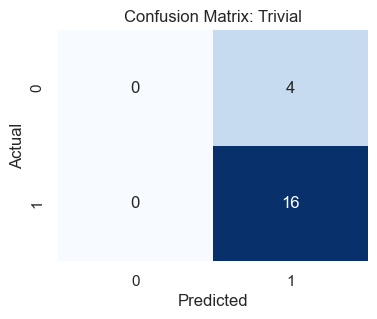

Naive Bayes          | 0.8000 | 0.8000 | 1.0000 | 0.8889 | 0.4375


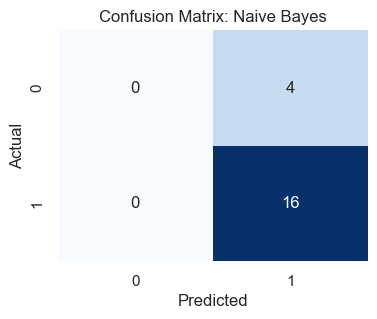

KNN                  | 0.7500 | 0.8235 | 0.8750 | 0.8485 | 0.4531


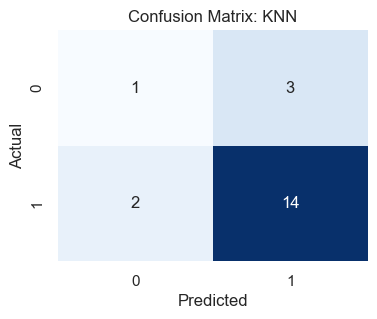

Logistic Regression  | 0.8000 | 0.8000 | 1.0000 | 0.8889 | 0.3906


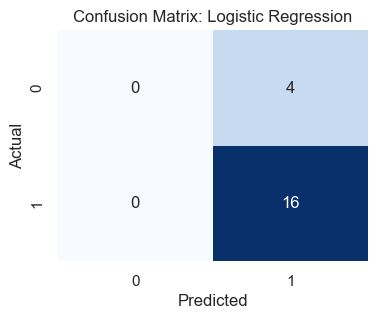

In [18]:
models = [
    ("Trivial", trivial_model, False, 0.5),
    ("Naive Bayes", nb_model, True, 0.5),
    ("KNN", knn_model, True, 0.5),
    ("Logistic Regression", log_reg, False, best_threshold)
]

print(f"{'Model':<20} | {'Acc':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6} | {'AUC':<6}")
print("-" * 70)

for name, model, has_proba_method, threshold in models:
    if name == "Logistic Regression":
        # Специфичный вызов для нашей реализации логрега (возвращает 1D массив)
        probs = model.predict_proba_positive(X_test)
        preds = (probs >= threshold).astype(int)
    
    elif name == "Trivial":
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test) # Возвращает 1D
        
    else:
        # Для KNN и NB
        preds = model.predict(X_test)
        raw_probs = model.predict_proba(X_test)
        
        # ИСПРАВЛЕНИЕ ЗДЕСЬ:
        # Если массив двумерный (как у NB: [prob_0, prob_1]), берем второй столбец.
        # Если массив одномерный (как у KNN: [prob_1]), используем его сразу.
        if raw_probs.ndim == 2:
            probs = raw_probs[:, 1]
        else:
            probs = raw_probs
        
    metrics = calculate_metrics(y_test, preds, probs)
    
    print(f"{name:<20} | {metrics['accuracy']:.4f} | {metrics['precision']:.4f} | "
          f"{metrics['recall']:.4f} | {metrics['f1']:.4f} | {metrics['roc_auc']:.4f}")
    
    plot_confusion_matrix(metrics['conf_matrix'], name)